# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("data.csv")

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.562,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


Look at class labels to see if dataset is imbalanced

In [3]:
label_counts = countmap(data[:target_class])

Dict{Int64,Int64} with 2 entries:
  0 => 16259
  1 => 1639

In [4]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.908425522404738
 0.09157447759526204

Get data ready for training

In [5]:
describe(data)

,variable,mean,min,median,max
,Symbol,Float64,Real,Float64,Real
1,Mean of the integrated profile,111.08,5.8125,115.078,192.617
2,Standard deviation of the integrated profile,46.5495,24.772,46.9475,98.7789
3,Excess kurtosis of the integrated profile,0.477857,-1.87601,0.22324,8.06952
4,Skewness of the integrated profile,1.77028,-1.79189,0.19871,68.1016
5,Mean of the DM-SNR curve,12.6144,0.213211,2.80184,223.392
6,Standard deviation of the DM-SNR curve,26.3265,7.37043,18.4613,110.642
7,Excess kurtosis of the DM-SNR curve,8.30356,-3.13927,8.43351,34.5398
8,Skewness of the DM-SNR curve,104.858,-1.97698,83.0646,1191.0
9,target_class,0.0915745,0,0.0,1


In [6]:
coerce!(data, :target_class=>Multiclass)
schema(data)

┌───────────────────────────────────────────────┬────────────────────────────────┬───────────────┐
│ _.names                                       │ _.types                        │ _.scitypes    │
├───────────────────────────────────────────────┼────────────────────────────────┼───────────────┤
│  Mean of the integrated profile               │ Float64                        │ Continuous    │
│  Standard deviation of the integrated profile │ Float64                        │ Continuous    │
│  Excess kurtosis of the integrated profile    │ Float64                        │ Continuous    │
│  Skewness of the integrated profile           │ Float64                        │ Continuous    │
│  Mean of the DM-SNR curve                     │ Float64                        │ Continuous    │
│  Standard deviation of the DM-SNR curve       │ Float64                        │ Continuous    │
│  Excess kurtosis of the DM-SNR curve          │ Float64                        │ Continuous    │
│  Skewnes

In [7]:
y, X = unpack(data, ==(:target_class), colname->true)

(CategoricalValue{Int64,UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17898×8 DataFrame. Omitted printing of 7 columns
│ Row   │  Mean of the integrated profile │
│       │ Float64                         │
├───────┼─────────────────────────────────┤
│ 1     │ 140.562                         │
│ 2     │ 102.508                         │
│ 3     │ 103.016                         │
│ 4     │ 136.75                          │
│ 5     │ 88.7266                         │
│ 6     │ 93.5703                         │
│ 7     │ 119.484                         │
│ 8     │ 130.383                         │
│ 9     │ 107.25                          │
│ 10    │ 107.258                         │
⋮
│ 17888 │ 121.375                         │
│ 17889 │ 98.7266                         │
│ 17890 │ 126.625                         │
│ 17891 │ 143.672                         │
│ 17892 │ 118.484                         │
│ 17893 │ 96.0                            │
│ 17894 │ 136.43 

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:target_class])) # gives 70:30 split

([2859, 3242, 436, 12919, 3279, 17651, 16341, 14975, 16060, 730  …  805, 13608, 9896, 11042, 13883, 3467, 112, 9612, 2792, 261], [1078, 16815, 4553, 12452, 10187, 17806, 8156, 16807, 2688, 1554  …  4126, 15656, 16102, 15077, 13659, 13276, 13241, 8204, 5417, 415])

In [9]:
train_counts = countmap(data[train,:target_class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.9084450830140486
 0.09155491698595147

In [10]:
test_counts = countmap(data[test,:target_class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.9083798882681564
 0.09162011173184358

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models(matching(X,y))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [12]:
@load KNNClassifier

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @061

## K Nearest Neighbors
* Use different values of k.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/
1. https://github.com/KristofferC/NearestNeighbors.jl

#### No Pre-Processing

In [13]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @825

In [14]:
KNN = machine(knn, X, y)

Machine{KNNClassifier} @645 trained 0 times.
  args: 
    1:	Source @259 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @953 ⏎ `AbstractArray{Multiclass{2},1}`


In [15]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @645.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Machine{KNNClassifier} @645 trained 1 time.
  args: 
    1:	Source @259 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @953 ⏎ `AbstractArray{Multiclass{2},1}`


In [16]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                │
├───────────────┼───────────────┼───────────────────────────────────────────┤
│ cross_entropy │ 0.487         │ [0.431, 0.411, 0.556, 0.59, 0.484, 0.452] │
│ acc           │ 0.972         │ [0.969, 0.975, 0.972, 0.97, 0.973, 0.973] │
└───────────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 0.223], [2.22e-16, 2.22e-16, ..., 2.22e-16], [0.511, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 0.223], [2.22e-16, 2.22e-16, ..., 0.223], [2.22e-16, 2.22e-16, ..., 36.0]], missing]


In [17]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{8},Float64,1,8},Distances.Euclidean,Float64}
  Number of points: 14915
  Dimensions: 8
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

#### With Pre-Processing

In [18]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @106

In [19]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:])
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @878.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


In [20]:
KNN = machine(knn, X_stand, y)

Machine{KNNClassifier} @819 trained 0 times.
  args: 
    1:	Source @942 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @697 ⏎ `AbstractArray{Multiclass{2},1}`


In [21]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @819.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Machine{KNNClassifier} @819 trained 1 time.
  args: 
    1:	Source @942 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @697 ⏎ `AbstractArray{Multiclass{2},1}`


In [22]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 0.393         │ [0.485, 0.355, 0.401, 0.381, 0.282, 0.452] │
│ acc           │ 0.979         │ [0.977, 0.981, 0.979, 0.979, 0.982, 0.978] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 0.223, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 0.223, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]


In [23]:
# evaluate!(KNN, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [24]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{8},Float64,1,8},Distances.Euclidean,Float64}
  Number of points: 14915
  Dimensions: 8
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

### GridSearch / RandomSearch

#### Euclidean

In [32]:
knn_grid = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @287

In [53]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=9, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [54]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @748],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @076

In [55]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @436 trained 0 times.
  args: 
    1:	Source @052 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @526 ⏎ `AbstractArray{Multiclass{2},1}`


In [56]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @436.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322
┌ Info: Attempting to evaluate 9 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/nuvTc/src/tuned_models.jl:501
Evaluating over 9 metamodels: 100%[=========================] Time: 0:00:01


Machine{ProbabilisticTunedModel{Grid,…}} @436 trained 1 time.
  args: 
    1:	Source @052 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @526 ⏎ `AbstractArray{Multiclass{2},1}`


In [57]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @233,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{8},Float64,1,8},Distances.Euclidean,Float64}
  Number of points: 12528
  Dimensions: 8
  Metric: Distances.Euclidean(0.0)
  Reordered: true,),)

In [58]:
best.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @233

#### Manhattan

In [59]:
knn_grid = KNNClassifier(metric=Chebyshev())

LoadError: UndefVarError: Chebyshev not defined

In [60]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=9, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [61]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @748],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @186

In [62]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @286 trained 0 times.
  args: 
    1:	Source @728 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @734 ⏎ `AbstractArray{Multiclass{2},1}`


In [63]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @286.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322
┌ Info: Attempting to evaluate 9 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/nuvTc/src/tuned_models.jl:501
Evaluating over 9 metamodels: 100%[=========================] Time: 0:00:01


Machine{ProbabilisticTunedModel{Grid,…}} @286 trained 1 time.
  args: 
    1:	Source @728 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @734 ⏎ `AbstractArray{Multiclass{2},1}`


In [64]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @641,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{8},Float64,1,8},Distances.Euclidean,Float64}
  Number of points: 12528
  Dimensions: 8
  Metric: Distances.Euclidean(0.0)
  Reordered: true,),)

In [65]:
best.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @641

### Learning Curve

In [71]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc, step=50)

(d, train_metric, valid_metric) = (10, 0.8, 0.9130087789305666)
(d, train_metric, valid_metric) = (60, 0.9666666666666667, 0.9349561053471668)
(d, train_metric, valid_metric) = (110, 0.9818181818181818, 0.9588986432561851)
(d, train_metric, valid_metric) = (160, 0.98125, 0.9692737430167597)
(d, train_metric, valid_metric) = (210, 0.9809523809523809, 0.9696727853152434)
(d, train_metric, valid_metric) = (260, 0.9769230769230769, 0.9672785315243416)
(d, train_metric, valid_metric) = (310, 0.9709677419354839, 0.9676775738228253)
(d, train_metric, valid_metric) = (360, 0.975, 0.9672785315243416)
(d, train_metric, valid_metric) = (410, 0.9658536585365853, 0.9688747007182761)
(d, train_metric, valid_metric) = (460, 0.9652173913043478, 0.9664804469273743)
(d, train_metric, valid_metric) = (510, 0.9627450980392157, 0.9708699122106943)
(d, train_metric, valid_metric) = (560, 0.9660714285714286, 0.9688747007182761)
(d, train_metric, valid_metric) = (610, 0.9672131147540983, 0.9684756584197926)
(

(d, train_metric, valid_metric) = (5160, 0.9748062015503876, 0.9732641660015962)
(d, train_metric, valid_metric) = (5210, 0.9744721689059501, 0.9732641660015962)
(d, train_metric, valid_metric) = (5260, 0.9739543726235741, 0.9732641660015962)
(d, train_metric, valid_metric) = (5310, 0.9740112994350283, 0.9732641660015962)
(d, train_metric, valid_metric) = (5360, 0.9740671641791044, 0.9728651237031125)
(d, train_metric, valid_metric) = (5410, 0.9739371534195933, 0.9732641660015962)
(d, train_metric, valid_metric) = (5460, 0.973992673992674, 0.9732641660015962)
(d, train_metric, valid_metric) = (5510, 0.9738656987295826, 0.9732641660015962)
(d, train_metric, valid_metric) = (5560, 0.9739208633093526, 0.9740622505985634)
(d, train_metric, valid_metric) = (5610, 0.9737967914438502, 0.9740622505985634)
(d, train_metric, valid_metric) = (5660, 0.9740282685512367, 0.9740622505985634)
(d, train_metric, valid_metric) = (5710, 0.9740805604203152, 0.9740622505985634)
(d, train_metric, valid_metri

(10:50:10010, Any[0.8, 0.9666666666666667, 0.9818181818181818, 0.98125, 0.9809523809523809, 0.9769230769230769, 0.9709677419354839, 0.975, 0.9658536585365853, 0.9652173913043478  …  0.973744769874477, 0.9737773152965661, 0.9739130434782609, 0.9741503604531411, 0.9744877049180328, 0.9747196738022426, 0.9746450304259635, 0.974066599394551, 0.9739959839357429, 0.9741258741258741], Any[0.9130087789305666, 0.9349561053471668, 0.9588986432561851, 0.9692737430167597, 0.9696727853152434, 0.9672785315243416, 0.9676775738228253, 0.9672785315243416, 0.9688747007182761, 0.9664804469273743  …  0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9736632083000798, 0.9740622505985634, 0.9744612928970471])

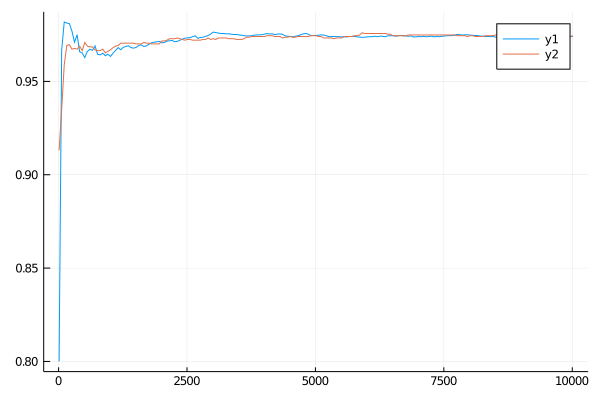

In [72]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

In [73]:
knn_final = KNNClassifier(K=best.best_model.K)

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @795

In [74]:
KNN_Final = machine(knn_final, X, y)

Machine{KNNClassifier} @594 trained 0 times.
  args: 
    1:	Source @816 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @044 ⏎ `AbstractArray{Multiclass{2},1}`


In [75]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @819.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/machines.jl:322


Machine{KNNClassifier} @819 trained 8 times.
  args: 
    1:	Source @942 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @697 ⏎ `AbstractArray{Multiclass{2},1}`


In [76]:
ŷ = MLJ.predict(KNN, X_stand[test,:]);

In [77]:
cross_entropy(ŷ, y[test]) |> mean

0.45569859135832835

In [78]:
acc(ŷ, y[test])

0.9783985102420857

In [79]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/cJmIS/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4852     │     90      │
├─────────────┼─────────────┼─────────────┤
│      1      │     26      │     402     │
└─────────────┴─────────────┴─────────────┘
